In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import io

def blockwise_dct(image, block_size=8):

    h, w = image.shape
    dct_image = np.zeros_like(image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = image[i:i + block_size, j:j + block_size]
            dct_block = cv2.dct(np.float32(block))
            dct_image[i:i + block_size, j:j + block_size] = dct_block

    return dct_image

In [ ]:
def blockwise_quantize_dct(dct_image, quant_matrix, block_size=8):

    h, w = dct_image.shape
    quantized_dct = np.zeros_like(dct_image)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = dct_image[i:i + block_size, j:j + block_size]
            quantized_block = np.round(block / quant_matrix)
            quantized_dct[i:i + block_size, j:j + block_size] = quantized_block

    return quantized_dct

def blockwise_dequantize_dct(quantized_dct, quant_matrix, block_size=8):

    h, w = quantized_dct.shape
    dequantized_dct = np.zeros_like(quantized_dct)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            block = quantized_dct[i:i + block_size, j:j + block_size]
            dequantized_block = block * quant_matrix
            dequantized_dct[i:i + block_size, j:j + block_size] = dequantized_block

    return dequantized_dct

In [ ]:
def blockwise_idct(dct_image, block_size=8):

    h, w = dct_image.shape
    image_reconstructed = np.zeros_like(dct_image, dtype=np.float32)

    for i in range(0, h, block_size):
        for j in range(0, w, block_size):
            dct_block = dct_image[i:i + block_size, j:j + block_size]
            block = cv2.idct(dct_block)
            image_reconstructed[i:i + block_size, j:j + block_size] = block

    return image_reconstructed

In [ ]:
def lossy_compression(image, quality=50, block_size=8):

    img = image.copy()

    h, w = img.shape
    new_h = ((h + block_size - 1) // block_size) * block_size
    new_w = ((w + block_size - 1) // block_size) * block_size
    padded_image = cv2.copyMakeBorder(img, 0, new_h - h, 0, new_w - w,
                                      cv2.BORDER_CONSTANT, value=0)

    base_quant_matrix = np.array([
        [16, 11, 10, 16, 24, 40, 51, 61],
        [12, 12, 14, 19, 26, 58, 60, 55],
        [14, 13, 16, 24, 40, 57, 69, 56],
        [14, 17, 22, 29, 51, 87, 80, 62],
        [18, 22, 37, 56, 68, 109, 103, 77],
        [24, 35, 55, 64, 81, 104, 113, 92],
        [49, 64, 78, 87, 103, 121, 120, 101],
        [72, 92, 95, 98, 112, 100, 103, 99]
    ])

    if quality < 50:
        scale = 5000 / quality
    else:
        scale = 200 - 2 * quality

    quant_matrix = np.floor((base_quant_matrix * scale + 50) / 100)
    quant_matrix = np.clip(quant_matrix, 1, 255).astype(np.float32)

    dct_image = blockwise_dct(padded_image, block_size)

    quantized_dct = blockwise_quantize_dct(dct_image, quant_matrix, block_size)

    original_size = padded_image.size * padded_image.itemsize
    compressed_size = np.count_nonzero(quantized_dct) * 2

    dequantized_dct = blockwise_dequantize_dct(quantized_dct, quant_matrix, block_size)

    image_reconstructed = blockwise_idct(dequantized_dct, block_size)

    image_reconstructed = image_reconstructed[:h, :w]

    image_reconstructed = np.clip(image_reconstructed, 0, 255).astype(np.uint8)

    if compressed_size > 0:
        compression_ratio = original_size / compressed_size
    else:
        compression_ratio = float('inf')

    return image_reconstructed, compression_ratio

In [ ]:
def lossless_compression(image):

    pil_img = Image.fromarray(image)

    buffer = io.BytesIO()
    pil_img.save(buffer, format="PNG")

    compressed_size = buffer.tell()

    original_size = image.size * image.itemsize

    compression_ratio = original_size / compressed_size

    return image, compression_ratio

In [ ]:
def display_compression_comparison(original, lossy, lossless, lossy_ratio, lossless_ratio):

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(lossy, cmap='gray')
    plt.title(f'Lossy (JPEG-like)\nCompression Ratio: {lossy_ratio:.2f}x')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(lossless, cmap='gray')
    plt.title(f'Lossless (PNG-like)\nCompression Ratio: {lossless_ratio:.2f}x')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
def main(image_path):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    if image is None:
        print(f"Error: Could not load image from {image_path}")
        return

    lossy_image, lossy_ratio = lossy_compression(image, quality=50)

    lossless_image, lossless_ratio = lossless_compression(image)

    display_compression_comparison(image, lossy_image, lossless_image, lossy_ratio, lossless_ratio)

    print(f"Lossy Compression Ratio: {lossy_ratio:.2f}x")
    print(f"Lossless Compression Ratio: {lossless_ratio:.2f}x")

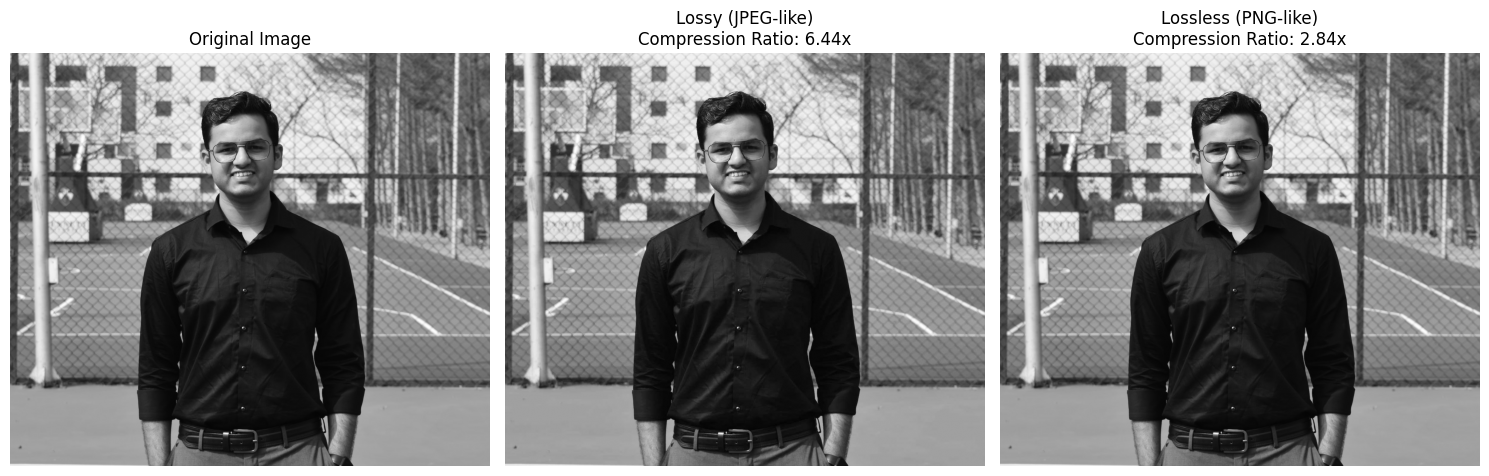

Lossy Compression Ratio: 6.44x
Lossless Compression Ratio: 2.84x


In [ ]:
if __name__ == "__main__":
    image_path = "/content/picture.jpg"
    main(image_path)

In [ ]:
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

def build_mnist_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

In [ ]:
model = build_mnist_model()
history = model.fit(x_train, y_train, epochs=3, validation_data=(x_test, y_test), batch_size=64)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 62s 64ms/step - accuracy: 0.8962 - loss: 0.3446 - val_accuracy: 0.9850 - val_loss: 0.0455
Epoch 2/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 79s 61ms/step - accuracy: 0.9830 - loss: 0.0521 - val_accuracy: 0.9897 - val_loss: 0.0330
Epoch 3/3
938/938 ━━━━━━━━━━━━━━━━━━━━ 83s 62ms/step - accuracy: 0.9896 - loss: 0.0338 - val_accuracy: 0.9897 - val_loss: 0.0334


In [ ]:
y_pred = model.predict(x_test).argmax(axis=1)
print(classification_report(y_test, y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step


'              precision    recall  f1-score   support\n\n           0       0.99      0.99      0.99       980\n           1       0.99      1.00      1.00      1135\n           2       0.99      0.99      0.99      1032\n           3       0.99      0.99      0.99      1010\n           4       0.99      1.00      0.99       982\n           5       0.98      0.99      0.99       892\n           6       0.99      0.99      0.99       958\n           7       0.98      0.99      0.99      1028\n           8       1.00      0.98      0.99       974\n           9       0.99      0.99      0.99      1009\n\n    accuracy                           0.99     10000\n   macro avg       0.99      0.99      0.99     10000\nweighted avg       0.99      0.99      0.99     10000\n'

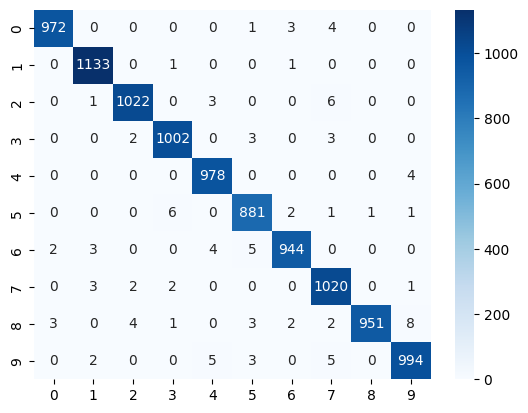

In [ ]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.show()

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


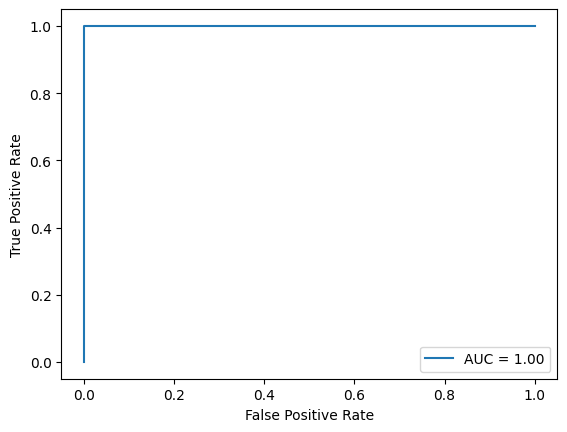

In [ ]:
fpr, tpr, _ = roc_curve(y_test, model.predict(x_test)[:, 1], pos_label=1)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

In [ ]:
def build_cifar10_model():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
cifar10 = tf.keras.datasets.cifar10
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

cifar_model = build_cifar10_model()
cifar_model.fit(x_train, y_train, epochs=5, validation_data=(x_test, y_test))

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 50ms/step - accuracy: 0.3908 - loss: 1.6806 - val_accuracy: 0.5722 - val_loss: 1.2334
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 79s 49ms/step - accuracy: 0.5983 - loss: 1.1334 - val_accuracy: 0.6368 - val_loss: 1.0300
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 74s 48ms/step - accuracy: 0.6582 - loss: 0.9687 - val_accuracy: 0.6498 - val_loss: 1.0071
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 74s 47ms/step - accuracy: 0.6994 - loss: 0.8574 - val_accuracy: 0.6617 - val_loss: 0.9814
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 89s 52ms/step - accuracy: 0.7293 - loss: 0.7749 - val_accuracy: 0.6728 - val_loss: 0.9454


In [ ]:
cifar10_y_pred = cifar_model.predict(x_test).argmax(axis=1)
print(classification_report(y_test, cifar10_y_pred))

313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step
              precision    recall  f1-score   support

           0       0.73      0.69      0.71      1000
           1       0.70      0.86      0.77      1000
           2       0.60      0.54      0.57      1000
           3       0.53      0.45      0.49      1000
           4       0.72      0.52      0.60      1000
           5       0.62      0.54      0.58      1000
           6       0.62      0.87      0.73      1000
           7       0.76      0.71      0.73      1000
           8       0.70      0.84      0.76      1000
           9       0.75      0.71      0.73      1000

    accuracy                           0.67     10000
   macro avg       0.67      0.67      0.67     10000
weighted avg       0.67      0.67      0.67     10000

